In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from prophet import Prophet

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [7]:
# Load cleaned data
df = pd.read_csv("../data/processed/train_clean.csv", parse_dates=["date"])

print("Shape:", df.shape)
print("Date range:", df["date"].min().date(), "to", df["date"].max().date())
print("Stores:", df["store"].nunique(), "Items:", df["item"].nunique())


Shape: (913000, 7)
Date range: 2013-01-01 to 2017-12-31
Stores: 10 Items: 50


In [8]:
def get_series(df, store_id, item_id):
    s = (
        df[(df["store"] == store_id) & (df["item"] == item_id)]
        .sort_values("date")[["date", "sales"]]
        .reset_index(drop=True)
    )
    return s

def time_split(series_df, test_size=0.2):
    n = len(series_df)
    split_idx = int(n * (1 - test_size))
    train = series_df.iloc[:split_idx].copy()
    test = series_df.iloc[split_idx:].copy()
    return train, test

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def metric_row(model_name, store_id, item_id, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = mape(y_true, y_pred)
    return {
        "model": model_name,
        "store": store_id,
        "item": item_id,
        "mae": mae,
        "rmse": rmse,
        "mape": mape_val,
    }


In [9]:
def run_baselines_for_series(series, store_id, item_id, test_size=0.2, window=30):
    train_s, test_s = time_split(series, test_size=test_size)
    y_true = test_s["sales"].values

    rows = []

    # Naive: last value of train
    naive_pred = np.full_like(y_true, train_s["sales"].iloc[-1], dtype=float)
    rows.append(metric_row("naive", store_id, item_id, y_true, naive_pred))

    # Moving average: mean of last window days
    ma_level = train_s["sales"].rolling(window).mean().iloc[-1]
    ma_pred = np.full_like(y_true, ma_level, dtype=float)
    rows.append(metric_row("ma_30d", store_id, item_id, y_true, ma_pred))

    return rows


In [10]:
def run_prophet_for_series(series, store_id, item_id, test_size=0.2):
    train_s, test_s = time_split(series, test_size=test_size)
    prophet_train = train_s.rename(columns={"date": "ds", "sales": "y"})
    prophet_test = test_s.rename(columns={"date": "ds", "sales": "y"})

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
    )
    m.fit(prophet_train)

    horizon = len(prophet_test)
    future = m.make_future_dataframe(periods=horizon, freq="D")
    forecast = m.predict(future)

    forecast_test = forecast.iloc[-horizon:]["yhat"].values
    y_true = prophet_test["y"].values

    return metric_row("prophet", store_id, item_id, y_true, forecast_test)


In [11]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

def run_lstm_for_series(series, store_id, item_id,
                        window=30, test_size=0.2,
                        epochs=10, batch_size=32):
    # scale
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series[["sales"]]).reshape(-1)

    # build sequences
    X, y = [], []
    for i in range(window, len(scaled)):
        X.append(scaled[i-window:i])
        y.append(scaled[i])
    X = np.array(X)[..., np.newaxis]  # (n, window, 1)
    y = np.array(y)

    # split on sequences (time-based)
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    if len(X_test) == 0:
        return None  # safety

    train_ds = SequenceDataset(X_train, y_train)
    test_ds = SequenceDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = LSTMForecaster(input_size=1, hidden_size=50, num_layers=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # train
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    # eval on test
    model.eval()
    with torch.no_grad():
        X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_pred_scaled = model(X_test_t).cpu().numpy().reshape(-1)

    # inverse scale
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1)
    # to inverse-transform y_test correctly:
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

    return metric_row("lstm", store_id, item_id, y_test_orig, y_pred)


In [12]:
stores = sorted(df["store"].unique())
items = sorted(df["item"].unique())

results = []

# Limit LSTM to first N series to keep runtime reasonable; set to None for all.
max_lstm_series = 50
lstm_count = 0

for s in stores:
    for it in items:
        series = get_series(df, s, it)

        # baselines
        results.extend(run_baselines_for_series(series, s, it))

        # prophet
        try:
            res_prophet = run_prophet_for_series(series, s, it)
            results.append(res_prophet)
        except Exception as e:
            print(f"Prophet failed for store {s}, item {it}: {e}")

        # lstm (optional subset)
        if max_lstm_series is None or lstm_count < max_lstm_series:
            try:
                res_lstm = run_lstm_for_series(series, s, it)
                if res_lstm is not None:
                    results.append(res_lstm)
                    lstm_count += 1
            except Exception as e:
                print(f"LSTM failed for store {s}, item {it}: {e}")


21:35:26 - cmdstanpy - INFO - Chain [1] start processing
21:35:26 - cmdstanpy - INFO - Chain [1] done processing
21:35:30 - cmdstanpy - INFO - Chain [1] start processing
21:35:30 - cmdstanpy - INFO - Chain [1] done processing
21:35:31 - cmdstanpy - INFO - Chain [1] start processing
21:35:31 - cmdstanpy - INFO - Chain [1] done processing
21:35:33 - cmdstanpy - INFO - Chain [1] start processing
21:35:33 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:37 - cmdstanpy - INFO - Chain [1] start processing
21:35:37 - cmdstanpy - INFO - Chain [1] done processing
21:35:38 - cmdstanpy - INFO - Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] done processing
21:35:40 - cmdstanpy - INFO - Chain [1] start processing
21:35:40 - cmdstanpy - INFO - Chain [1] done processing
21:35:42 - cmdstanpy - INFO - Chain [1] start processing
21:35:42 - cmdstanpy - INFO - Chain [1]

In [13]:
results_df = pd.DataFrame(results)
results_df.head()


,model,store,item,mae,rmse,mape
0,naive,1,1,5.844262,7.186622,34.317485
1,ma_30d,1,1,7.322222,9.241738,30.894660
2,prophet,1,1,4.076076,5.011968,22.637337
3,lstm,1,1,4.688321,5.904253,25.033260
4,naive,1,2,23.404372,27.785773,35.439289


In [14]:
summary = (
    results_df
    .groupby("model")[["mae", "rmse", "mape"]]
    .mean()
    .sort_values("rmse")
)
summary


,mae,rmse,mape
model,,,
prophet,6.802973,8.461805,14.414211
lstm,8.649399,10.805964,18.587760
naive,17.528339,21.313835,28.638371
ma_30d,18.058820,22.104872,28.407273


In [15]:
idx = results_df.groupby(["store", "item"])["rmse"].idxmin()
winners = results_df.loc[idx].sort_values("model")
winners["model"].value_counts()


model
prophet    500
Name: count, dtype: int64

## Bar Plot - Average metrics by model

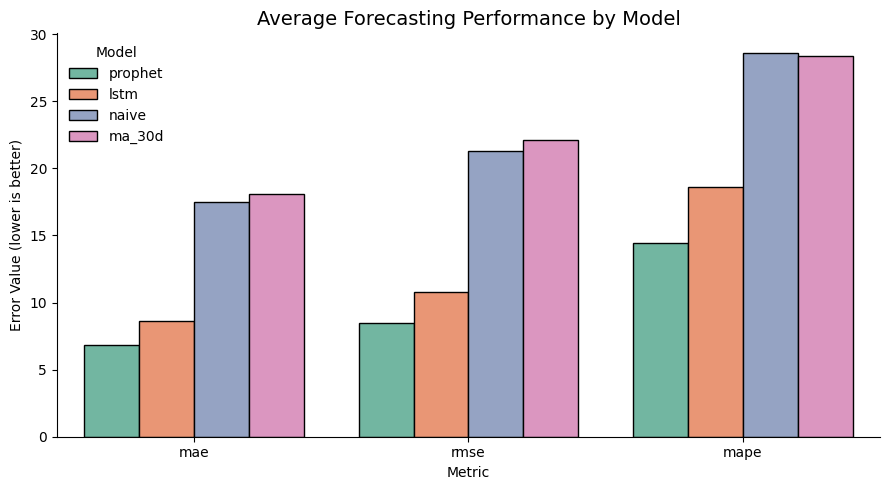

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert summary table for plotting
summary_reset = summary.reset_index().melt(
    id_vars="model", var_name="metric", value_name="value"
)

plt.figure(figsize=(9,5))
sns.barplot(
    data=summary_reset,
    x="metric",
    y="value",
    hue="model",
    palette="Set2",  # try "mako", "crest", "rocket", "viridis", "coolwarm"
    edgecolor="black"
)

plt.title("Average Forecasting Performance by Model", fontsize=14)
plt.ylabel("Error Value (lower is better)")
plt.xlabel("Metric")
plt.legend(title="Model", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()


## Heatmap of metrics

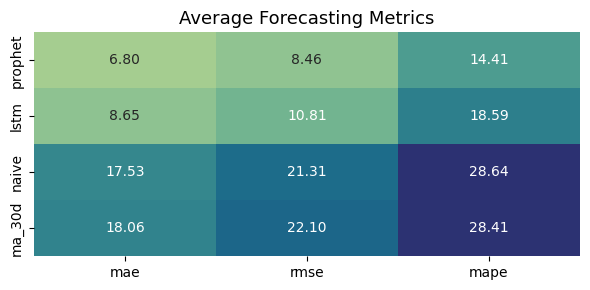

In [22]:
plt.figure(figsize=(6,3))
sns.heatmap(
    summary[['mae','rmse','mape']],
    annot=True,
    fmt=".2f",
    cmap="crest",
    cbar=False
)
plt.title("Average Forecasting Metrics", fontsize=13)
plt.ylabel("")
plt.tight_layout()
plt.show()
